## QuantAQ Data
Data are available via an API, but only for members of the QuantAQ organization maintaining each group of sensors.

For those who are members of a QuantAQ organizatio, the code below walks through the basics of accessing data via the API. For everyone else please skip ahead to the Exploratory Data Analysis Code Block to continue the analysis.


## How to Access QuantAQ data with python through an API

The first step is to sign up for a free QuantAQ account: https://app.quant-aq.com/auth/sign-up

<img src="./images/QuantAQ-SignUp.png" alt="QuantAQ Signup" width="400"/>

The next step is to obtain an API Key:

From the API Documentation

Obtaining an API key
Authentication is handled using HTTP Basic Auth which consists of sending an API key that is unique to your account with each request. This key should be kept secret and not shared with anyone. This API key is tied to your user account and will only allow you to take actions within your assigned scope of permissions.

You can generate an API key for your account by visiting the Developer section within the QuantAQ Cloud and clicking Generate New Key in the upper right-hand corner of your screen. It is recommended that you set this key as an environment variable on your computer with the name QUANTAQ_APIKEY.

To include your API key in your request, add an HTTP Authorization header, consisting of a usernameand password. When using httpie, you can use the -aflag to indicate authorization. The API key serves as the username and the password should be left blank.

<img src="./images/QuantAQ-Key.png" alt="QuantAQ API-Key" width="800"/>

Next, please install the python package available for working with the API which is fully described here: https://github.com/quant-aq/py-quantaq.git

In [2]:
try:
    import quantaq
    print("quantaq is already installed")
except ImportError:
    !pip install git+https://github.com/quant-aq/py-quantaq.git

quantaq is already installed


Now we are ready to interact with the API. We will start by setting up the API client. This will require you to input the API Key that was created in the previous step.

In [5]:
# import the library
import quantaq
import os, getpass
# Set the API key as an environment variable within the notebook session
os.environ['QUANTAQ_APIKEY'] = getpass.getpass("Enter your API key: ")
# Initialize the QuantAQ client
client = quantaq.QuantAQAPIClient(api_key=os.environ['QUANTAQ_APIKEY'])

In order to verify that things are working as expected, first explore some metadata about the client created in the previous step.

In [6]:
# verify account information
whoami = client.whoami()
print (whoami)
# You can retrieve a list of all the organizations visible to you:
organizations = client.organizations.list()
print (organizations)
# You can retrieve a list of all the devices visible to you:
devices = client.devices.list()
print (devices)

{'confirmed': True, 'email': 'topstschool@ciesin.columbia.edu', 'first_name': 'TOPS', 'id': 2704, 'is_administrator': False, 'last_name': 'SCHOOL', 'last_seen': '2025-02-28T18:17:47.085848', 'member_since': '2025-01-31T14:38:35.980542', 'role': 1, 'username': 'topstschool'}
[{'created_on': '2023-10-18T20:43:11.197345+00:00', 'description': 'South Bronx Unite brings together neighborhood residents, community organizations, academic institutions, and allies to improve and protect the social, environmental, and economic future of Mott Haven and Port Morris.', 'devices': ['MOD-PM-01153', 'MOD-PM-01156', 'MOD-PM-01150', 'MOD-00478', 'MOD-PM-01158', 'MOD-PM-01322', 'MOD-00695', 'MOD-PM-01331', 'MOD-PM-01154', 'MOD-00479', 'MOD-PM-01152', 'MOD-00482', 'MOD-PM-01162', 'MOD-00480', 'MOD-00693', 'MOD-PM-01317', 'MOD-PM-01334', 'MOD-PM-01332', 'MOD-PM-01145', 'MOD-PM-01160', 'MOD-PM-01333', 'MOD-PM-01324', 'MOD-PM-01328', 'MOD-PM-01315', 'MOD-PM-01149', 'MOD-PM-01163', 'MOD-PM-01148', 'MOD-00697'

Ok, it looks like we have access. In the example above we have partnered with a community organization in the South Bronx of New York City called South Bronx Unite. More on that later, but assuming you do have access to an organization, here are some examples of how you might want to interact with the API.

From the list of devices above we are able to grab the device Serial Numbers (sn). The sn will be used in order to query the devices.

First lets look at the most recent data from a single device; sn='MOD-00480'

In [ ]:
# You can limit the return to just the most recent data points from a single device:
recent = client.data.list(sn='MOD-00480', sort="timestamp,asc", limit=10)
for r in recent:
    print(r)

{'co': None, 'geo': {'lat': 40.806, 'lon': -73.93}, 'met': {'rh': 90.0, 'temp': 6.1, 'wd': 0.0, 'ws': None, 'ws_scalar': 0.0}, 'model': {'gas': {'co': None, 'no': None, 'no2': None, 'o3': None}, 'pm': {'pm1': 11669, 'pm10': 11671, 'pm25': 11670}}, 'no': None, 'no2': None, 'o3': None, 'pm1': 4.18, 'pm10': 167.16, 'pm25': 6.95, 'raw_data_id': 83357948, 'rh': 90.0, 'sn': 'MOD-00480', 'temp': 6.1, 'timestamp': '2000-01-01T00:01:01', 'timestamp_local': '1999-12-31T19:01:01', 'url': 'https://api.quant-aq.com/v1/devices/MOD-00480/data/83357866'}
{'co': None, 'geo': {'lat': None, 'lon': None}, 'met': {'rh': 39.2, 'temp': 25.9, 'wd': 0.0, 'ws': None, 'ws_scalar': 0.0}, 'model': {'gas': {'co': None, 'no': None, 'no2': None, 'o3': None}, 'pm': {'pm1': 11669, 'pm10': 11671, 'pm25': 11670}}, 'no': None, 'no2': None, 'o3': None, 'pm1': 2.12, 'pm10': 4.33, 'pm25': 2.46, 'raw_data_id': 62314430, 'rh': 39.2, 'sn': 'MOD-00480', 'temp': 25.9, 'timestamp': '2023-09-15T16:45:28', 'timestamp_local': '2023-0

Alternatively, we could select a data range and query all of the devices over that range. 

Since this will result in a lot of data returned, we will utilize the python pandas library in order to manage it.

In [ ]:
# import libraries
import pandas as pd
from quantaq.utils import to_dataframe
df = []
# To get a list of all devices:
devices = client.devices.list()
for device in devices:
    serialNumber = device['sn']
    # For each device, query the API for data from November 3rd to November 10th, 2024
    for each in pd.date_range(start='2024-11-03', end='2024-11-10'):
        df.append(
            to_dataframe(client.data.bydate(sn=serialNumber, date=str(each.date())))
        )
df = pd.concat(df)
# Drop some fields that are not useful for this analysis
fields_to_drop = ['met.rh', 'met.temp', 'met.wd', 'met.ws', 
                  'met.ws_scalar', 'model.gas.co', 'model.gas.no', 
                  'model.gas.no2', 'model.gas.o3', 'model.pm.pm1', 
                  'model.pm.pm10', 'model.pm.pm25']
df = df.drop(columns=fields_to_drop, errors='ignore')
# save the output file to a csv
df.to_csv('./images/quant_aq_data_11-1-24_11-10-24.csv', index=False)

The routine above has resulted in a csv file of data in the South Bronx, New York City from November 3rd through November 10th, 2024. 

This corresponds to the highly publicized week when Canadian wildfire smoke rolled into New York City, turning the skyline orange.

<img src="./images/pbs_wildfires.png" alt="PBS Wildfire NY" width="1000"/>

Source: https://www.pbs.org/newshour/world/photos-skies-over-canada-and-u-s-darkened-by-hazardous-wildfire-haze

# To continue with the lesson, if you do not have access to a QuantAQ Organization, you can use the following code to load the data from the CSV file

In [17]:
try: 
    import pandas as pd
    print("pandas is already installed")
except:
    import pandas as pd

# read the csv file
# load the data into a pandas dataframe for further analysis
df = pd.read_csv('./data/quant_aq_data_11-1-24_11-10-24.csv')
# view the data set level metadata
df.info()
# display the first 5 rows of the data
df.head()

pandas is already installed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466319 entries, 0 to 466318
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   pm1              456115 non-null  float64
 1   pm10             456115 non-null  float64
 2   pm25             456115 non-null  float64
 3   raw_data_id      466319 non-null  int64  
 4   sn               466319 non-null  object 
 5   timestamp        466319 non-null  object 
 6   timestamp_local  466319 non-null  object 
 7   url              466319 non-null  object 
 8   geo.lat          345342 non-null  float64
 9   geo.lon          345342 non-null  float64
 10  co               160190 non-null  float64
 11  no               160244 non-null  float64
 12  no2              160307 non-null  float64
 13  o3               160307 non-null  float64
 14  rh               166594 non-null  float64
 15  temp             166594 non-null  float64
 16  wd        

,pm1,pm10,pm25,raw_data_id,sn,timestamp,timestamp_local,url,geo.lat,geo.lon,co,no,no2,o3,rh,temp,wd,ws,ws_scalar
0,3.772,4.851,4.440,651646120,MOD-PM-01144,2024-11-03 23:59:54,2024-11-03 18:59:54,https://api.quant-aq.com/v1/devices/MOD-PM-011...,40.813,-73.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.380,5.920,4.077,651646116,MOD-PM-01144,2024-11-03 23:58:54,2024-11-03 18:58:54,https://api.quant-aq.com/v1/devices/MOD-PM-011...,40.813,-73.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.195,11.662,4.758,651646118,MOD-PM-01144,2024-11-03 23:57:54,2024-11-03 18:57:54,https://api.quant-aq.com/v1/devices/MOD-PM-011...,40.813,-73.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.178,8.217,4.670,651646119,MOD-PM-01144,2024-11-03 23:56:54,2024-11-03 18:56:54,https://api.quant-aq.com/v1/devices/MOD-PM-011...,40.813,-73.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.679,5.183,4.228,651643807,MOD-PM-01144,2024-11-03 23:55:54,2024-11-03 18:55:54,https://api.quant-aq.com/v1/devices/MOD-PM-011...,40.813,-73.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This provides us with a nice peek at the data, but in order to evaluate it statistically we may want to include additional Exploratory Data Analysis.

We will proceed through a number of checks.

First lets evaluate the data quality.

### Data Quality Check
- Identify missing values per column.
- Check duplicate entries.
- Verify data types.

matplotlib is already installed
Data Quality Check:
                 Missing Values  Missing Percentage Data Type
pm1                       10204            2.188202   float64
pm10                      10204            2.188202   float64
pm25                      10204            2.188202   float64
raw_data_id                   0            0.000000     int64
sn                            0            0.000000    object
timestamp_local               0            0.000000    object
url                           0            0.000000    object
geo.lat                  120977           25.942970   float64
geo.lon                  120977           25.942970   float64
co                       306129           65.647979   float64
no                       306075           65.636399   float64
no2                      306012           65.622889   float64
o3                       306012           65.622889   float64
rh                       299725           64.274670   float64
temp              

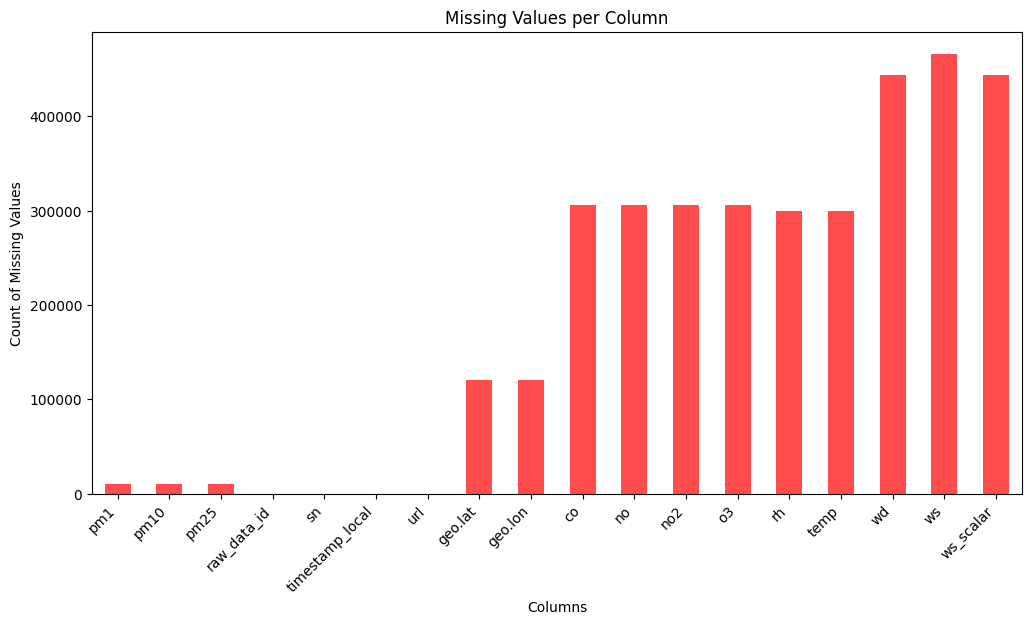

In [22]:
try:
    import matplotlib.pyplot as plt
    print("matplotlib is already installed")
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

# 1. Data Quality Check

# Count missing values per column
missing_values = df.isnull().sum()

# Identify duplicate rows
duplicate_count = df.duplicated().sum()

# Data types of each column
data_types = df.dtypes

# Create a summary DataFrame for data quality check
data_quality_check = pd.DataFrame({
    "Missing Values": missing_values,
    "Missing Percentage": (missing_values / len(df)) * 100,
    "Data Type": data_types
})

# Print results
print("Data Quality Check:")
print(data_quality_check)
print("\nDuplicate Rows:", duplicate_count)

# Plot missing values as a bar chart
plt.figure(figsize=(12, 6))
missing_values.plot(kind='bar', color='red', alpha=0.7)
plt.title("Missing Values per Column")
plt.xlabel("Columns")
plt.ylabel("Count of Missing Values")
plt.xticks(rotation=45, ha='right')
plt.show()


The results show that the dataset we created has a lot of missing information in the following areas:

- **Geolocation:** 25.94% missing
- **Gas Concentrations:** Over 65% missing
- **Wind Speed (ws):** Completely missing
- **Wind Direction (wd):** Completely missing
- **Wind Speed Scalar (ws_scalar):** Completely missing

Despite these gaps, the dataset has no duplicate rows, which suggests that the data we do have is accurate.

We expected to have less information on gas concentrations since our device list showed that only a subset of the sensors were collecting those data.

Nonetheless, to work with this data effectively, there may be times when we would fill in the missing values (this is called "imputation") or other times when we would remove the incomplete rows. The approach will depend on what we want to achieve with our analysis. 

In this case we will remove the rows with missing geolocation, and drop the missing wind variables.


In [ ]:
# Remove the windspeed-related columns
df = df.drop(columns=['ws','wd','ws_scalar'])

# Remove rows where geolocation (latitude or longitude) is missing
df = df.dropna(subset=['geo.lat', 'geo.lon'])

# Verify the changes
updated_missing_values = df.isnull().sum()

# Display the updated missing values report
print("Updated Missing Values After Cleaning:")
print(updated_missing_values)

Updated Missing Values After Cleaning:
pm1                 10150
pm10                10150
pm25                10150
raw_data_id             0
sn                      0
timestamp_local         0
url                     0
geo.lat                 0
geo.lon                 0
co                 259433
no                 259432
no2                259432
o3                 259432
rh                 253655
temp               253655
dtype: int64


The table shows how many values are missing in each column after removing the wind speed (ws) variable and dropping rows with missing geolocation data (geo.lat, geo.lon). 

Here's what this means:

- **Geolocation Columns (geo.lat, geo.lon):**
  - 0 missing values
  - All rows without location data were successfully removed.

- **PM1, PM10, and PM25 Columns:**
  - Around 10,150 missing values
  - This is a small fraction of the dataset.

- **Gas Concentration Variables (co, no, no2, o3):**
  - Over 259,000 missing values
  - These are unavailable for more than half of the dataset.

- **Humidity (rh) and Temperature (temp):**
  - Missing in over 253,000 rows
  - This could impact any climate-related analysis.

Overall, while geolocation issues have been resolved, missing data in other important columns could still be a concern. However for our use case these missing data are OK, so let's continue with the Exploratory Data Analysis and produce a set of summary statistics.

### Summary Statistics
- Compute basic statistics (mean, median, min, max, standard deviation).
- Identify any outliers.

Summary Statistics:
                 pm1           pm10           pm25   raw_data_id  \
count  456115.000000  456115.000000  456115.000000  4.663190e+05   
mean        9.466834      22.755803      10.448499  5.092192e+08   
std        22.041518      39.382921      22.792656  1.936031e+08   
min         0.000000       0.000000       0.000000  2.465914e+08   
25%         2.631000       5.860000       3.115000  2.507089e+08   
50%         4.620000      13.206000       5.410000  6.521533e+08   
75%         7.370000      26.680000       8.710000  6.541043e+08   
max       436.000000    3162.520000     451.380000  6.560563e+08   

             geo.lat        geo.lon             co             no  \
count  345342.000000  345342.000000  160190.000000  160244.000000   
mean       40.814714     -73.914103     887.225754       7.170733   
std         0.028976       0.026221     445.003334      25.767744   
min        40.686000     -74.024000     239.920000       1.330000   
25%        40.809000  

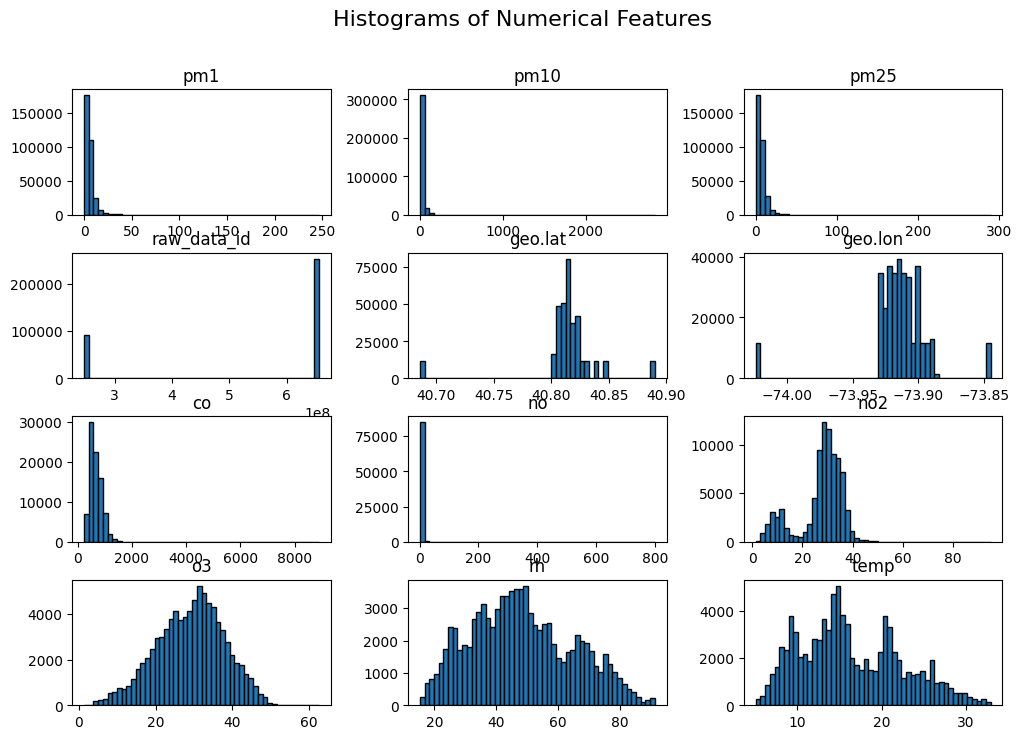

In [26]:
# Print summary statistics
print("Summary Statistics:")
print(summary_stats)

# Plot histograms for key variables
df.hist(figsize=(12, 8), bins=50, edgecolor='black', grid=False)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()

The summary statistics give us some important insights:

- **Particulate Matter (PM1, PM10, PM2.5):**
  - These pollutants have a lot of variability in their concentrations.
  - The maximum values are much higher than the average (mean), which means there are some very high readings compared to most of the data.
  - This suggests there might be pollution spikes or outliers in the data that need closer examination.

- **Gas Concentrations (co, no, no2, o3):**
  - These gases also show large standard deviations.
  - A large standard deviation means there is a lot of fluctuation in the readings, indicating changes in air quality over time.

#### Insights from Histograms

Histograms can tell us more about how the data is distributed:

- **Most Environmental Variables:**
  - They are right-skewed, meaning lower values are more common.
  - There are some high values that occur less frequently, creating long tails in the histograms.

- **Temperature (temp) and Relative Humidity (rh):**
  - These variables have a relatively normal distribution, meaning their values are spread out in a bell-shaped curve.

- **Pollutants (like no and co):**
  - These have extreme values that stand out.
  - These outliers might need further investigation to understand why they are so high.

#### Conclusion

- While the data shows some normal distributions, like temperature and humidity, there are many variables with high variability and extreme values.
- Understanding these patterns can help identify areas that need more attention, such as possible pollution spikes or fluctuations in air quality.

Will will continue with the EDA looking at the data as a time series.

### Time Series Analysis
- Ensure timestamps are in datetime format (to allow proper time-based analysis).
- Resample data to hourly and daily averages (to observe trends at different time scales).
- Plot time series graphs for key particulate, gas, and weather variables.

C:\Users\kyttm\AppData\Local\Temp\ipykernel_35796\4064969124.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_avg = df.resample('H').mean(numeric_only=True)


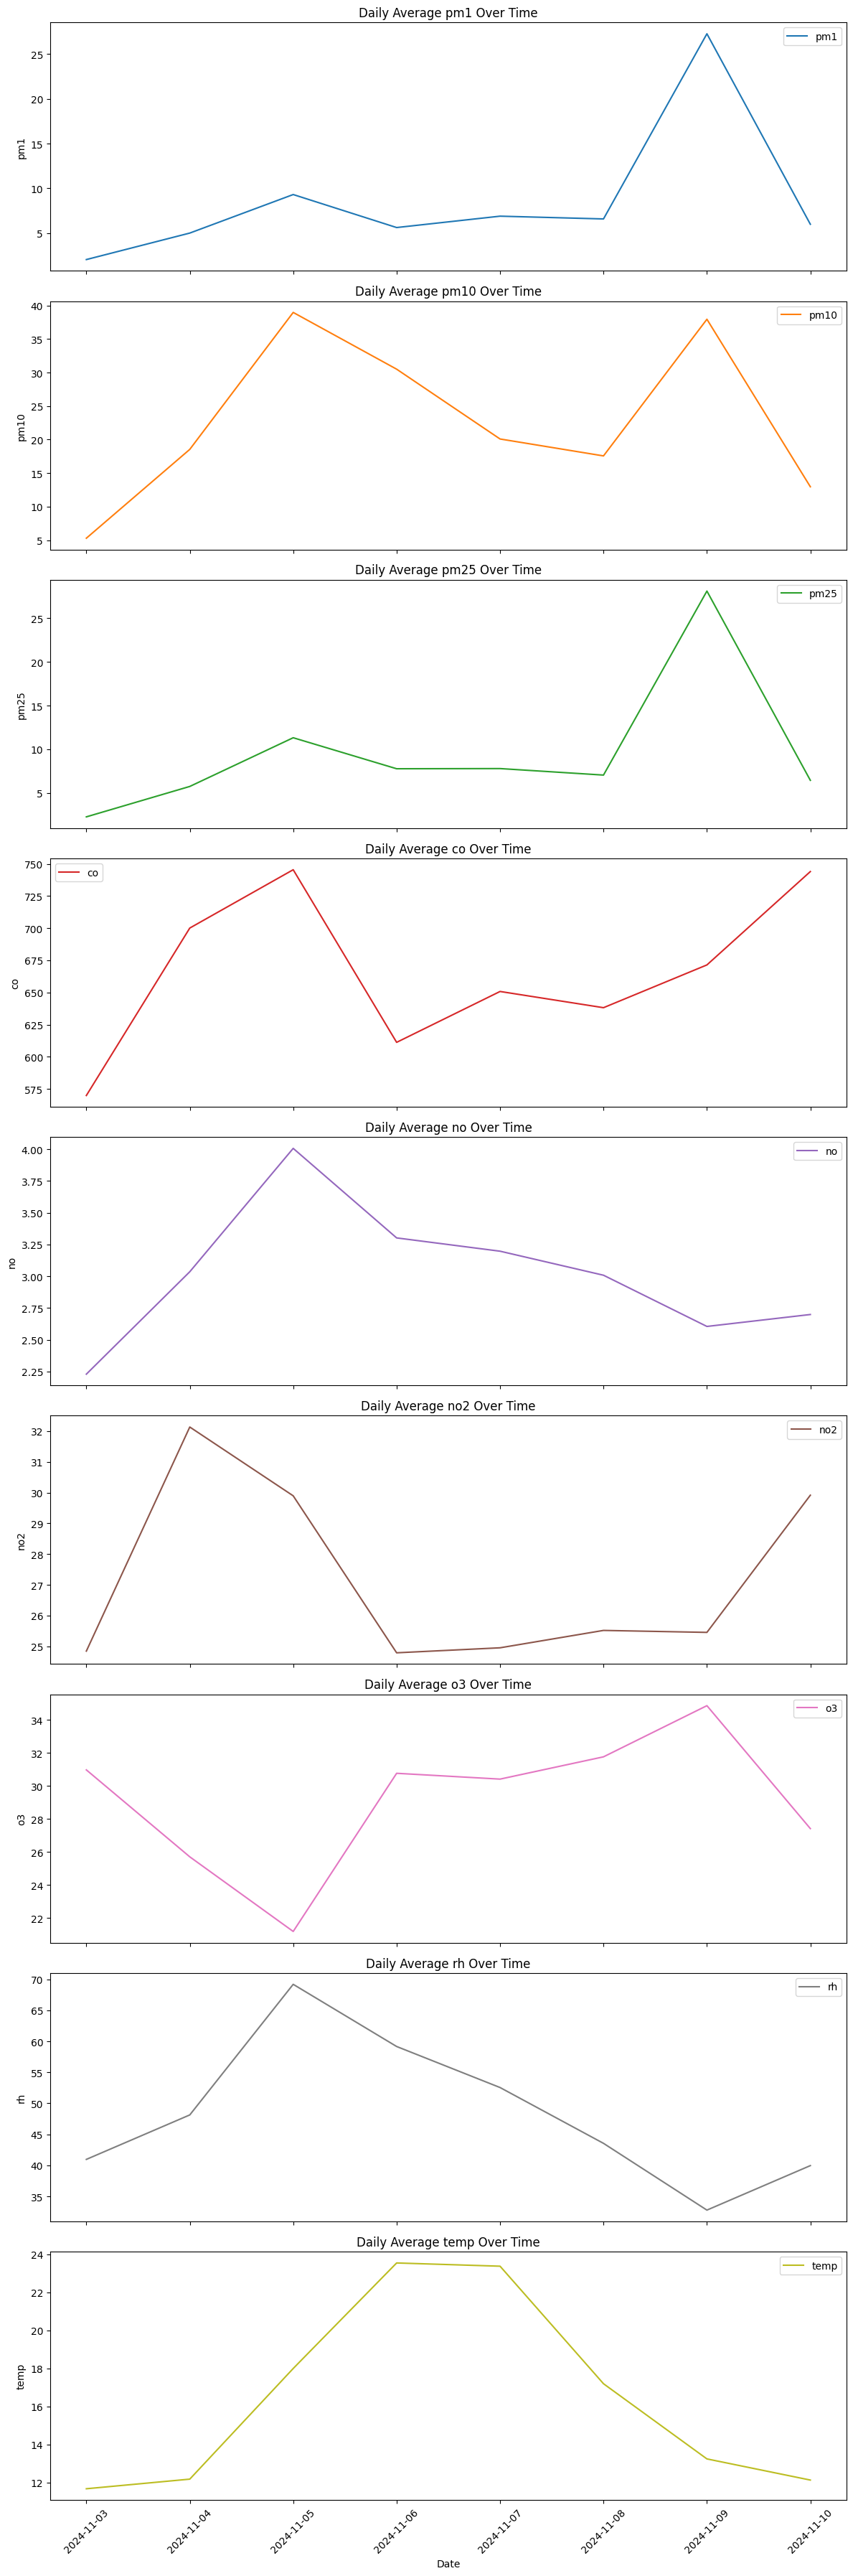

Hourly Averages:
                          pm1      pm10      pm25   raw_data_id    geo.lat  \
timestamp                                                                    
2024-11-03 00:00:00  2.322850  5.518133  2.503565  5.394389e+08  40.814682   
2024-11-03 01:00:00  1.969871  4.761291  2.125212  5.394670e+08  40.814682   
2024-11-03 02:00:00  1.840166  4.318591  1.988155  5.394950e+08  40.814682   
2024-11-03 03:00:00  1.886492  3.970948  2.025505  5.395232e+08  40.814682   
2024-11-03 04:00:00  1.847204  3.725806  1.971984  5.395514e+08  40.814682   

                       geo.lon          co        no        no2         o3  \
timestamp                                                                    
2024-11-03 00:00:00 -73.914277  613.407938  2.638208  28.839938  27.186917   
2024-11-03 01:00:00 -73.914277  606.739896  2.230625  28.390125  26.291229   
2024-11-03 02:00:00 -73.914277  596.673333  1.790292  27.858833  26.136167   
2024-11-03 03:00:00 -73.914277  608.389167  1.

In [32]:
# Ensure timestamp is in datetime format
df.index = pd.to_datetime(df.index)

# Resample data to hourly and daily averages (excluding non-numeric columns)
hourly_avg = df.resample('H').mean(numeric_only=True)
daily_avg = df.resample('D').mean(numeric_only=True)

# Define PM, gas, and weather variables
pm_gas_weather_vars = ['pm1', 'pm10', 'pm25', 'co', 'no', 'no2', 'o3', 'rh', 'temp']

# Plot time series for PM, gas, and weather variables
fig, axes = plt.subplots(nrows=len(pm_gas_weather_vars), ncols=1, figsize=(12, 4 * len(pm_gas_weather_vars)), sharex=True)

# Loop through selected columns and plot their time series
for i, col in enumerate(pm_gas_weather_vars):
    axes[i].plot(daily_avg.index, daily_avg[col], label=col, color='C' + str(i % 10))
    axes[i].set_ylabel(col)
    axes[i].set_title(f"Daily Average {col} Over Time")
    axes[i].legend()

plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display first few rows of resampled data
print("Hourly Averages:")
print(hourly_avg.head())

print("\nDaily Averages:")
print(daily_avg.head())


### Interpretation of the Results

This combined data shows us some interesting patterns:

#### Particulate Matter (PM1, PM10, PM2.5)

- All three PM metrics show noticeable fluctuations.
- Some days have significantly higher pollution levels.
- These peaks could be due to increased pollution sources, such as:
  - Traffic
  - Construction
  - Meteorological factors like low wind dispersion
  - Likely due to the Canadian wildfires during this period

#### Gas Pollutants (CO, NO, NO2, O3)

- **CO (Carbon Monoxide):**
  - Exhibits periodic peaks.
  - Suggests sources like vehicular emissions, fuel combustion, and possibly the Canadian wildfires.
- **NO and NO2 (Nitrogen Oxides):**
  - Common traffic-related pollutants.
  - Display fluctuations and possible spikes during high traffic hours.
- **O3 (Ozone):**
  - Shows a different pattern from NO2.
  - Often peaks when NO2 is lower, supporting the expected photochemical relationship.

#### Weather Conditions (RH, Temp)

- **Relative Humidity (RH):**
  - Varies over time.
  - Could influence secondary aerosol formation.
- **Temperature (Temp):**
  - Follows a more gradual trend.
  - Impacts ozone production and pollutant dispersion.
  - The wildfires could also have contributed to changes in temperature patterns.

### Key Observations

- PM levels have periodic spikes, suggesting events or changing pollution conditions.
- NO2 and O3 appear inversely related, which is typical in urban pollution chemistry.
- Weather conditions influence pollutant trends, as temperature and humidity affect dispersion and chemical reactions.
- The Canadian wildfires are likely a significant factor in the observed pollution levels and fluctuations.

## The daily data has already unmasked some interesting patterns, we might be able to learn more by exploring on an hourly timescale. Let's go ahead and do that for the key pollution variables, and focusing on November 9-10.

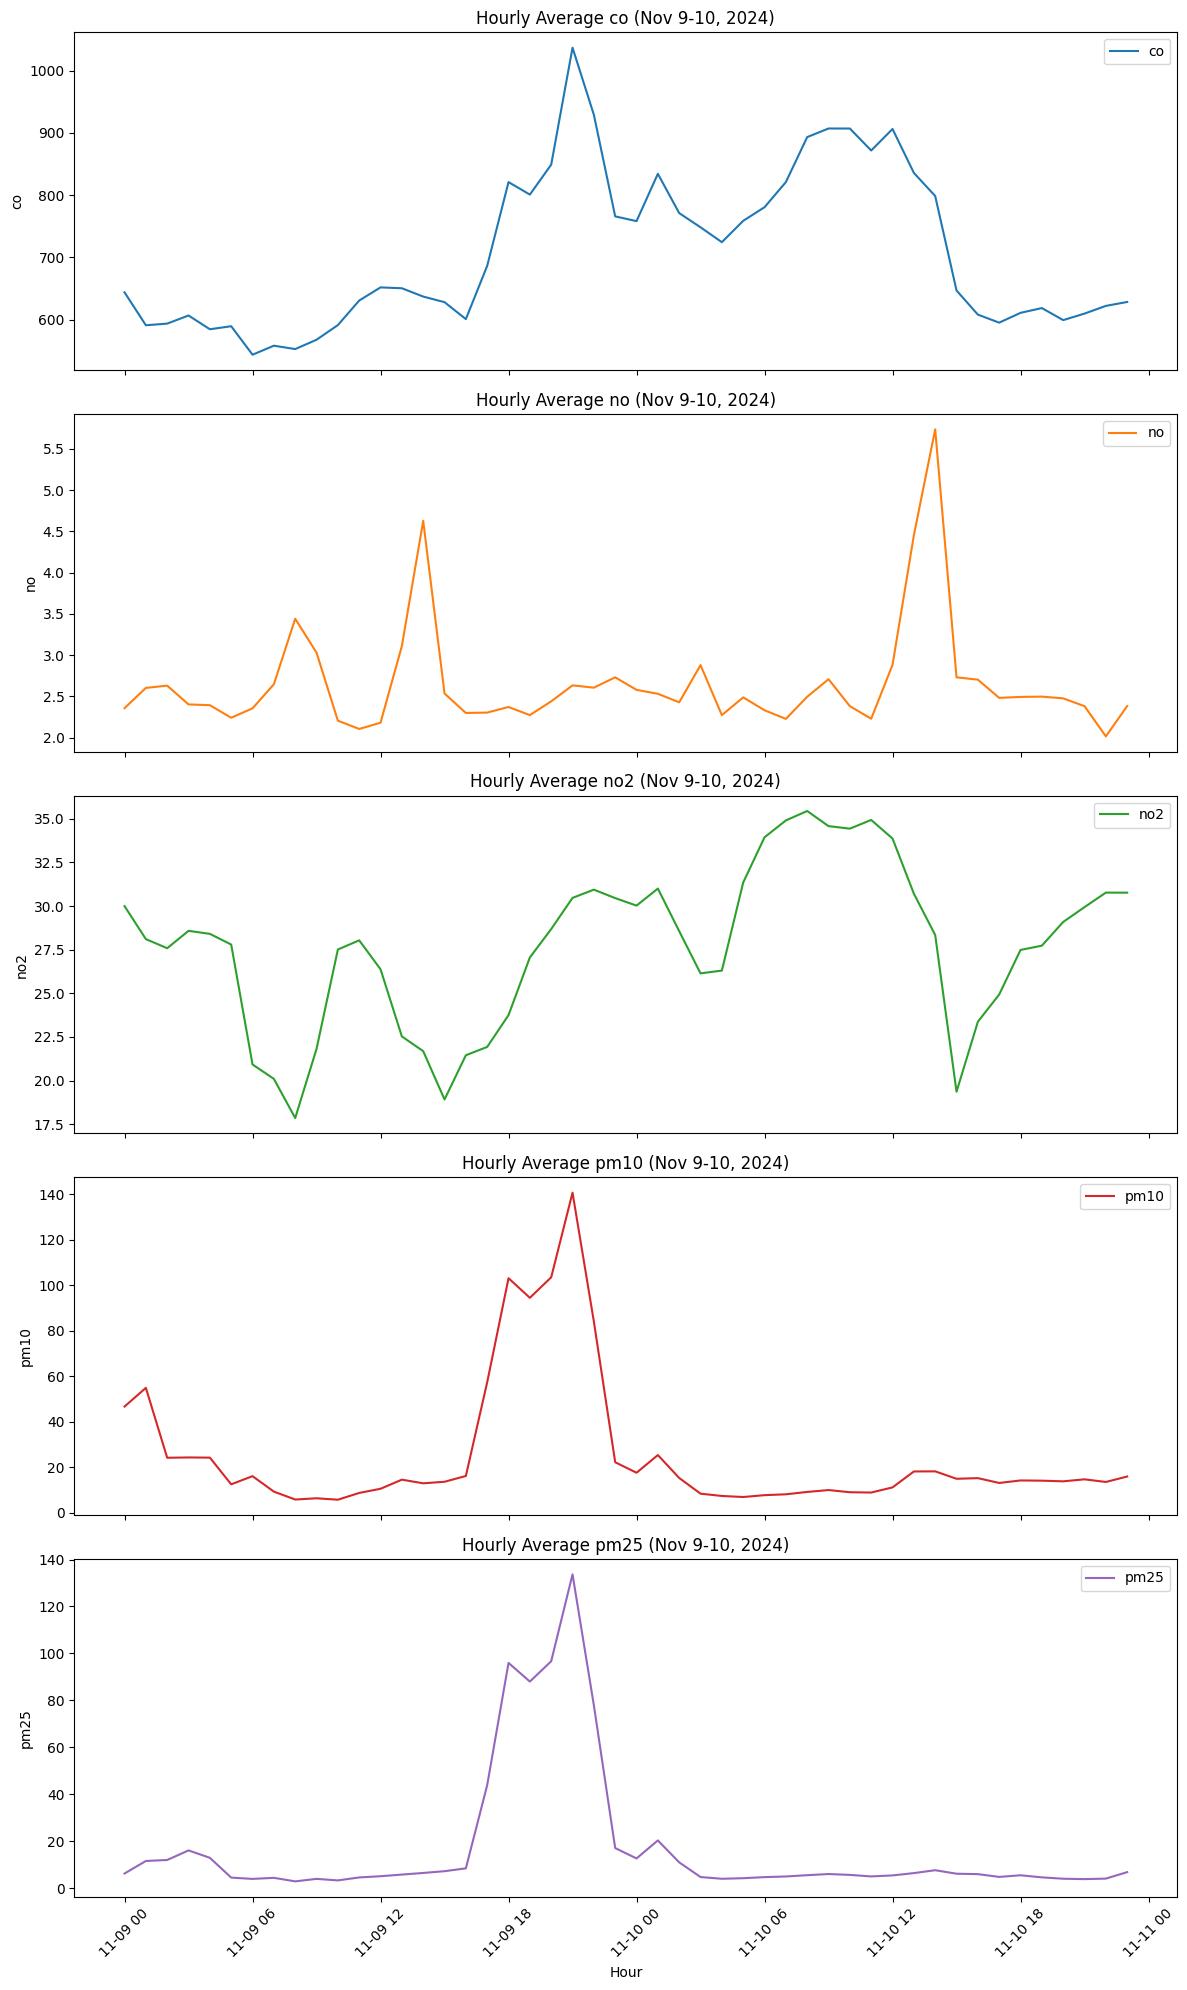

In [34]:
# Increase temporal resolution to hourly averages for traffic-related pollutants
traffic_related_vars = ['co', 'no', 'no2', 'pm10', 'pm25']
hourly_avg_traffic = hourly_avg[traffic_related_vars]

# Filter data for November 9 and 10, 2024
start_date = "2024-11-09"
end_date = "2024-11-10"
hourly_avg_traffic_filtered = hourly_avg_traffic.loc[start_date:end_date]

# Plot time series for hourly traffic-related pollutants during wildfire impacts
fig, axes = plt.subplots(nrows=len(traffic_related_vars), ncols=1, figsize=(12, 4 * len(traffic_related_vars)), sharex=True)

# Loop through selected traffic-related variables and plot their time series
for i, col in enumerate(traffic_related_vars):
    axes[i].plot(hourly_avg_traffic_filtered.index, hourly_avg_traffic_filtered[col], label=col, color='C' + str(i % 10))
    axes[i].set_ylabel(col)
    axes[i].set_title(f"Hourly Average {col} (Nov 9-10, 2024)")
    axes[i].legend()

plt.xlabel("Hour")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

By analyzing hourly averages instead of daily data, we can better observe patterns throughout the day. The pollutants most influenced by vehicular emissions—CO, NO, NO2, PM10, and PM2.5—are also most likely to show variations throughout the day, so let's focus on them:

#### Particulate Matter (PM10 & PM2.5)

- Significant elevations in PM levels suggest a major contribution from the Canadian wildfires.
- Unlike typical traffic-related trends, PM levels may remain high outside peak commuting hours.
- This indicates regional smoke transport rather than just local vehicle emissions.

#### Carbon Monoxide (CO)

- Increased levels across the day could be due to a combination of wildfire smoke and traffic emissions.
- CO levels may linger longer than usual due to the persistent presence of wildfire plumes.

#### Nitric Oxide (NO) & Nitrogen Dioxide (NO2)

- **NO (Nitric Oxide):**
  - Still shows some peaks during rush hours.
  - However, the trends might be less pronounced due to higher background pollution from wildfires.
- **NO2 (Nitrogen Dioxide):**
  - Formation may be affected by smoke chemistry.
  - This could alter typical photochemical processes.

### Key Observations

- PM concentrations remain elevated even outside rush hours, confirming the influence of wildfires.
- CO levels are consistently high, suggesting an extended pollution event rather than just traffic sources.
- NO and NO2 still follow some vehicle-related trends but may be modified by interactions with wildfire smoke.







### Spatial Analysis
- Check geolocation coverage.
- Plot available latitude/longitude data points.

### Correlation Analysis
- Identify relationships between pollutants and meteorological data.

In [45]:
try:
    import folium
    from folium.plugins import HeatMap
    print("folium is already installed")
except:
    !pip install folium
    import folium
    from folium.plugins import HeatMap


# Ensure timestamps are sorted to allow proper time slicing
df = df.sort_index()

# Now filter for wildfire event dates (Nov 9-10, 2024)
df_spatial = df.loc["2024-11-09":"2024-11-10"].copy()

# Drop rows where geolocation or selected pollutants are missing
df_spatial = df_spatial.dropna(subset=['geo.lat', 'geo.lon', 'pm25', 'co', 'no', 'no2'])

# Define map center (mean sensor location)
map_center = [df_spatial["geo.lat"].mean(), df_spatial["geo.lon"].mean()]
m = folium.Map(location=map_center, zoom_start=12, tiles="CartoDB Positron")  # Change tiles if needed

# Prepare heatmap layers for different pollutants
pollutants = ['pm25', 'co', 'no', 'no2']
for pollutant in pollutants:
    heat_data = df_spatial[['geo.lat', 'geo.lon', pollutant]].values.tolist()
    HeatMap(heat_data, radius=10, blur=15, max_zoom=13, name=pollutant).add_to(m)

# Add layer control to toggle pollutants
folium.LayerControl().add_to(m)

# Save map as an HTML file for viewing in a browser
m.save("wildfire_spatial_analysis.html")

# Display map if running in a Jupyter Notebook
m




folium is already installed


In [18]:
# Reload necessary libraries since execution state was reset
#import ace_tools as tools

# 1. Data Quality Check

# Count missing values per column
missing_values = df.isnull().sum()

# Identify duplicate rows
duplicate_count = df.duplicated().sum()

# Data types
data_types = df.dtypes

# 2. Summary Statistics
summary_stats = df.describe()

# 3. Time Series Analysis - Converting timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resampling to daily averages
daily_avg = df.resample('D').mean()

# 4. Spatial Analysis - Checking geolocation coverage
geo_coverage = df[['geo.lat', 'geo.lon']].dropna().describe()

# 5. Correlation Analysis - Checking relationships between pollutants and meteorological data
corr_matrix = df.corr(numeric_only=True)

# Display results
tools.display_dataframe_to_user(name="Missing Values", dataframe=missing_values)
tools.display_dataframe_to_user(name="Duplicate Count", dataframe=pd.DataFrame({"Duplicates": [duplicate_count]}))
tools.display_dataframe_to_user(name="Data Types", dataframe=pd.DataFrame(data_types, columns=["Type"]))
tools.display_dataframe_to_user(name="Summary Statistics", dataframe=summary_stats)
tools.display_dataframe_to_user(name="Daily Averages", dataframe=daily_avg)
tools.display_dataframe_to_user(name="Geolocation Coverage", dataframe=geo_coverage)
tools.display_dataframe_to_user(name="Correlation Matrix", dataframe=corr_matrix)


TypeError: agg function failed [how->mean,dtype->object]